In [1]:
import os
import random
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import albumentations as albu
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from tqdm.notebook import trange, tqdm
from torch.utils.tensorboard import SummaryWriter
from torchsampler import ImbalancedDatasetSampler
from torchvision import models
import torchvision.transforms as transforms
#from torchsummary import summary
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, average_precision_score
from sklearn.model_selection import GroupShuffleSplit
from pydicom import dcmread
import glob
import pickle
import scipy
from efficientnet_pytorch import EfficientNet
from datetime import datetime
seed = 10
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [2]:
dataDF = pd.read_csv('forTrainingDataFold.csv', dtype={'StudyInstanceUID': 'string', 'SeriesInstanceUID':'string', 'SOPInstanceUID':'string'})
dataDF = dataDF.set_index('SOPInstanceUID')
dataDF = dataDF.drop(['StudyInstanceUID','SeriesInstanceUID','rv_lv_ratio_lt_1'], axis=1)

In [3]:
dataDF.head()

,pe_present_on_image,acute,chronic,leftsided_pe,rightsided_pe,central_pe,rv_lv_ratio_gte_1,qa_motion,qa_contrast,flow_artifact,true_filling_defect_not_pe,negative_exam_for_pe,chronic_pe,acute_and_chronic_pe,indeterminate,img_pos,patient_position,fold
SOPInstanceUID,,,,,,,,,,,,,,,,,,
c0f3cb036d06,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,-234.5,HFS,3
f57ffd3883b6,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,-252.5,HFS,3
41220fda34a3,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,-432.5,HFS,3
13b685b4b14f,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,-434.5,HFS,3
be0b7524ffb4,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,-436.5,HFS,3


In [4]:
# Construct path mapping dict for jpg files 
listOfDCMfiles = glob.glob('data/train/*/*/*.dcm')

imageID2pathDict = {}

for eachPath in listOfDCMfiles:
    imageID = eachPath.split('/')[-1][:-4]
    imageID2pathDict[imageID] = eachPath

In [5]:
# Load training labels
gtLabelDict = pickle.load(open('data/CNNtrainingLabel.p','rb'))

In [6]:
sampleImageID = list(gtLabelDict.keys())[5]
print(gtLabelDict[sampleImageID])

[0. 0. 0. 0. 0. 0. 0. 1.]


# helper Functions

In [7]:
# Helper functions

def get_training_augmentation():
    train_transform = [
        albu.ShiftScaleRotate(scale_limit=0.05, rotate_limit=30, shift_limit=0.05, p=1, border_mode=0),
        albu.IAAAdditiveGaussianNoise(p=0.1),
        albu.IAAPerspective(p=0.2),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.3,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.3,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.3,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    '''
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    '''
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

In [8]:
def window(img, WL=50, WW=350):
    upper, lower = WL+WW//2, WL-WW//2
    X = np.clip(img.copy(), lower, upper)
    X = X - np.min(X)
    X = X / np.max(X)
    X = (X*255.0).astype('uint8')
    return X

In [9]:
class Dataset(BaseDataset):
    def __init__(
            self, 
            dataframe=None, 
            augmentation=None,
            transform=None,
            dirPath=None,
    ):
        self.dataframe = dataframe
        self.ids = self.dataframe.index.values.tolist()     
        self.augmentation = augmentation
        self.transform=transform
        self.dirPath = dirPath
    
    def __getitem__(self, i):
        thisID = self.ids[i]
        
        #jpgPath = imageID2pathDict[thisID]
        #image = cv2.imread(jpgPath)
        
        dcmPath = imageID2pathDict[thisID]
        dcm_data = dcmread(dcmPath)
        image = dcm_data.pixel_array * int(dcm_data.RescaleSlope) + int(dcm_data.RescaleIntercept)
        image = np.stack([window(image, WL=-600, WW=1500),
                          window(image, WL=40, WW=400),
                          window(image, WL=100, WW=700)], 2)
        
        target = gtLabelDict[thisID]    
        target = target.astype(np.float32)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image)
            image = sample['image']
        
        '''
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image)
            image = sample['image']
        '''
        
        image = image.astype(np.float32)
        #image = np.rollaxis(image, -1, 0)  
        #image = image.transpose((2, 0, 1))
        
        if self.transform:
            image = self.transform(image)
        
        return image, target
        
    def __len__(self):
        return len(self.ids)

In [10]:
def resnet50_model():
    myModel = models.resnet50(pretrained=True)
    num_ftrs = myModel.fc.in_features
    myModel.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(p = 0.2),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Linear(64, 8),
        )
    return myModel

In [11]:
# Custom weighted loss function
class customWeightedBCEwithLogits(nn.Module):
    def __init__(self, PE_pos_weight = 3.0, other_pos_weight = [30.0, 30.0, 3.0, 3.0, 3.0, 1.2, 0.5]):
        super(customWeightedBCEwithLogits, self).__init__()
        self.image_PE_PosWeight = torch.tensor(PE_pos_weight, requires_grad=False).cuda()
        self.otherLabels_PosWeight = torch.tensor(other_pos_weight, requires_grad=False).cuda()
        self.criterion1 = nn.BCEWithLogitsLoss(pos_weight=self.image_PE_PosWeight)
        self.criterion2 = nn.BCEWithLogitsLoss(pos_weight=self.otherLabels_PosWeight)

    def forward(self, inputs, targets):
        loss1 = self.criterion1(inputs[:,0:1], targets[:,0:1])
        loss2 = self.criterion2(inputs[:,1:], targets[:,1:])
        return loss1+loss2

In [12]:
def train_loop(model, train_loader, valid_loader):
    # Train one epoch
    train_total = train_correct = train_cost = 0
    model.train()
    for x, y in tqdm(train_loader):
        x = x.cuda()
        y = y.cuda()
        optimizer.zero_grad()
        z = model(x)
        train_total += y.size(0)
        train_correct += ((torch.sigmoid(z[:,0])>0.5) == (y[:,0]>0.5)).sum().item()
        loss = customLoss(z, y)
        loss.backward()
        optimizer.step()
        train_cost += loss.item()
    return train_cost/train_total, train_correct/train_total

def valid_loop(model, train_loader, valid_loader):
    # Evaluate on validation  data 
    val_total = val_correct = val_cost = 0
    model.eval()
    with torch.no_grad():
        for x_val, y_val in tqdm(valid_loader):
            x_val = x_val.cuda()
            y_val = y_val.cuda()
            z = model(x_val)
            val_total += y_val.size(0)
            val_correct += ((torch.sigmoid(z[:,0])>0.5) == (y_val[:,0]>0.5)).sum().item()
            loss = customLoss(z, y_val)
            val_cost += loss.item()
    return val_cost/val_total, val_correct/val_total

def main_loop(n_epochs, model, train_loader, valid_loader):
    for epoch in range(n_epochs):
        print('epoch ' + str(epoch) + ':')
        train_avgCost, train_acc = train_loop(model, train_loader, valid_loader)
        val_avgCost, val_acc = valid_loop(model, train_loader, valid_loader)
        print('train_cost: %.4f, train_acc: %.4f, val_cost: %.4f, val_acc: %.4f'\
              % (train_avgCost, train_acc, val_avgCost, val_acc))
        now = datetime.now().strftime("%Y%m%d_%H%M")
        modelPath = 'models/CNNmodel/CNNmodel_01_cv0_epoch' + str(epoch) + '_' + now +'.pth'
        print('saving: ',modelPath)
        torch.save(model, modelPath)

In [13]:
myModel = resnet50_model()
myModel = myModel.cuda()

In [14]:
# Prepare train variables and parameters
col_names = ['train_cost', 'train_acc', 'val_cost', 'val_acc']
resultsDF = pd.DataFrame(columns = col_names)

epochCount = 0
optimizer =torch.optim.Adam(myModel.parameters(), lr=0.00005)

customLoss = customWeightedBCEwithLogits()

In [15]:
# prepare dataset and dataloader
preTrainDF = dataDF[dataDF['fold']==4]
trainDF = dataDF[dataDF['fold']!=0]
valDF = dataDF[dataDF['fold']==0]

my_pretrain_dataset = Dataset(
    dataframe= preTrainDF,
    augmentation=get_training_augmentation(),
    transform=data_transform,
)

my_train_dataset = Dataset(
    dataframe= trainDF,
    augmentation=get_training_augmentation(),
    transform=data_transform,
)

my_val_dataset = Dataset(
    dataframe= valDF,
    augmentation=None,
    transform=data_transform,
)

myPreTrainLoader = DataLoader(my_pretrain_dataset, batch_size=48, shuffle=True, num_workers=4)
myTrainLoader = DataLoader(my_train_dataset, batch_size=42, shuffle=True, num_workers=4)
myValidLoader = DataLoader(my_val_dataset, batch_size=42, shuffle=True, num_workers=4)

1429585
label: [0. 0. 0. 0. 0. 0. 0. 1.]
(8,)
image shape: torch.Size([3, 512, 512])


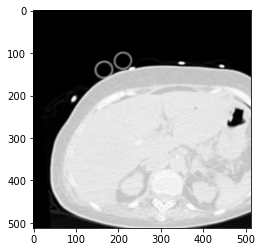

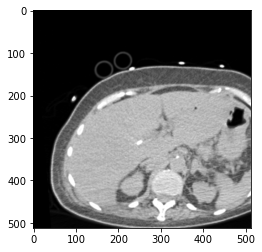

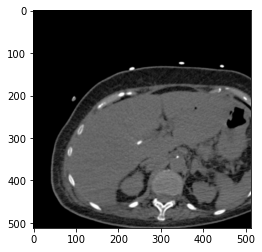

In [16]:
# Sanity Check

print(my_train_dataset.__len__())

oneItem = my_pretrain_dataset.__getitem__(35)
print('label:', oneItem[1])
print(oneItem[1].shape)
print('image shape:', oneItem[0].shape)
for eachInd in range(3):
    plt.figure()
    plt.imshow(oneItem[0][eachInd,:,:], cmap='gray')

# pre-Training

In [17]:
ind = 0

for name, child in myModel.named_children():
    for name2, params in child.named_parameters():
        print('block index:', str(ind), name, name2)
    ind = ind +1

block index: 0 conv1 weight
block index: 1 bn1 weight
block index: 1 bn1 bias
block index: 4 layer1 0.conv1.weight
block index: 4 layer1 0.bn1.weight
block index: 4 layer1 0.bn1.bias
block index: 4 layer1 0.conv2.weight
block index: 4 layer1 0.bn2.weight
block index: 4 layer1 0.bn2.bias
block index: 4 layer1 0.conv3.weight
block index: 4 layer1 0.bn3.weight
block index: 4 layer1 0.bn3.bias
block index: 4 layer1 0.downsample.0.weight
block index: 4 layer1 0.downsample.1.weight
block index: 4 layer1 0.downsample.1.bias
block index: 4 layer1 1.conv1.weight
block index: 4 layer1 1.bn1.weight
block index: 4 layer1 1.bn1.bias
block index: 4 layer1 1.conv2.weight
block index: 4 layer1 1.bn2.weight
block index: 4 layer1 1.bn2.bias
block index: 4 layer1 1.conv3.weight
block index: 4 layer1 1.bn3.weight
block index: 4 layer1 1.bn3.bias
block index: 4 layer1 2.conv1.weight
block index: 4 layer1 2.bn1.weight
block index: 4 layer1 2.bn1.bias
block index: 4 layer1 2.conv2.weight
block index: 4 layer

In [18]:
# Freeze everything except block index 9
trainBlock = [9]

ind = 0
for name, child in myModel.named_children():
    if ind not in trainBlock:
        for name2, params in child.named_parameters():
            params.requires_grad = False
    ind = ind +1

In [19]:
main_loop(1, myModel, myPreTrainLoader, myValidLoader)

epoch 0:



train_cost: 0.0147, train_acc: 0.9477, val_cost: 0.0171, val_acc: 0.9443
saving:  models/CNNmodel/CNNmodel_01_cv0_epoch0_20201013_0636.pth


# Train for 3 more epochs

In [20]:
#myModel = torch.load('models/CNNmodel/CNNmodel_01_epoch0_20201008_0038.pth')
#myModel.cuda()
#torch.cuda.empty_cache()

In [21]:
# Unfreeze everything before further training
for name, child in myModel.named_children():
    for name2, params in child.named_parameters():
        params.requires_grad = True

In [22]:
# Train for 3 more epochs
main_loop(3, myModel, myTrainLoader, myValidLoader)

epoch 0:



train_cost: 0.0112, train_acc: 0.9582, val_cost: 0.0111, val_acc: 0.9607
saving:  models/CNNmodel/CNNmodel_01_cv0_epoch0_20201013_1523.pth
epoch 1:



train_cost: 0.0091, train_acc: 0.9657, val_cost: 0.0115, val_acc: 0.9639
saving:  models/CNNmodel/CNNmodel_01_cv0_epoch1_20201014_0012.pth
epoch 2:



train_cost: 0.0079, train_acc: 0.9693, val_cost: 0.0121, val_acc: 0.9660
saving:  models/CNNmodel/CNNmodel_01_cv0_epoch2_20201014_0901.pth


In [23]:
# Train for 3 more epochs
main_loop(1, myModel, myTrainLoader, myValidLoader)

epoch 0:



train_cost: 0.0069, train_acc: 0.9730, val_cost: 0.0140, val_acc: 0.9581
saving:  models/CNNmodel/CNNmodel_01_cv0_epoch0_20201014_2159.pth
